# Problem Statement
One way that SHAP does the interpratation on images is on a *group of features*, in other words, pixels can be grouped together to form a **super pixel** and explanation is done on these super pixels.

This means, an image is devided to a number of segments, and the explainer quantifies the marginal contribution of each segment to the model predcition.

'azureml interpret' contrib packages, offers this functionality, but with no visualization.

Here in this notebook, we are using the pretrained 'ImageNet' model from keras to explain four random images using 'image_explainer' from 'azureml-contrib-interpret' package.
Then we use a set of utility functions (outside azureml-contrib-interpret package) to visualzie the resluts from the explanation.

We set up this on **Azure Machine Learnign Compute Instance**, you can also clone the repo on your local machine.If running on local, please remember to provide the config.json file with the following information. 

{
    "subscription_id": "",
    "resource_group": "",
    "workspace_name": ""
}

# Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from azureml.contrib.interpret import image_explainer
from azureml.core import Experiment
from azureml.core.workspace import Workspace
import numpy as np
from utils import utils
import matplotlib.pylab as plt

Using TensorFlow backend.
Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (flake8 3.8.1 (c:\users\chengz\appdata\local\continuum\anaconda3\envs\aml_intepret\lib\site-packages), Requirement.parse('flake8<=3.7.9,>=3.1.0; python_version >= "3.6"')).


# data and configuration


files: Here we define a list of four random images that will be explainded by the explainer from interpret.

n_segments: We also set number of segments to define super pixels.

dim, col_channe: these are to reshape the images.

top_n: this is used for the final visualization, to display explaination for the top_n predictions from the model.

In [2]:
file1 = 'test_data/balloon.jpg'
file2 = "test_data/bird.jpg"
file3 = 'test_data/cat.jpg' 
file4 = "test_data/truck.jpg"

files = [file1, file2, file3, file4]

n_segments = 50

dim = (224, 224)
col_channel = 3
top_n = 2
experiment_name = 'demo'

In [3]:
ws = Workspace.from_config()
#print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep="\n")
experiment = Experiment(ws, experiment_name)
run = experiment.start_logging()

In [4]:
img_list = []
img_arr_list = []

for file in files:
    img = image.load_img(file, target_size=dim)
    img_arr = image.img_to_array(img)
    img_list.append(img)
    img_arr_list.append(img_arr)
   

The first two images are classified correctly by the model and the other two are mis-classified, we want to see the marginal contribution of each super-pixel to the classification task: 

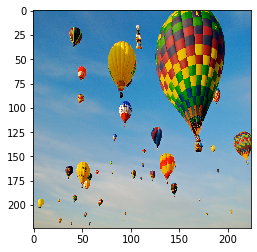

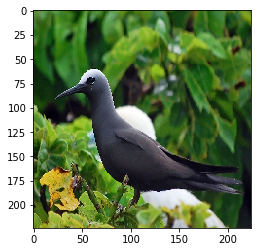

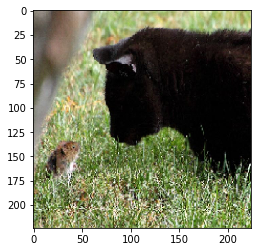

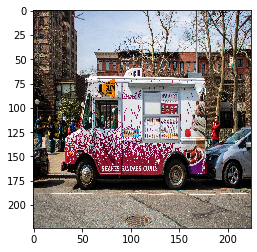

In [5]:
for _img in img_list:
    plt.imshow(_img)
    plt.show()

Loading the model and setting up the explainer:

In [6]:
model = VGG16()
explainer = image_explainer.ImageExplainer(model, dim + (col_channel, ))
y = explainer.explain_local(files, n_segments=n_segments, classes=None)

100%|██████████| 1/1 [02:27<00:00, 147.03s/it]


In [7]:
shap_values_list = utils.prep_shaps(y, len(files), n_segments)

Let's visualize the results from explaination:

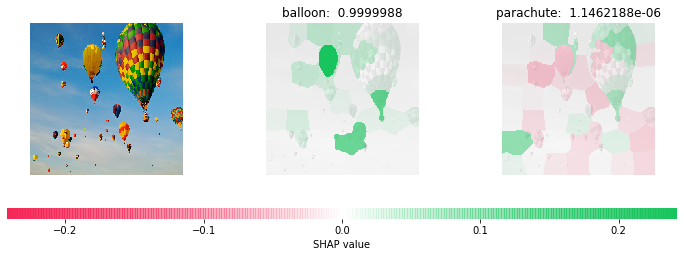

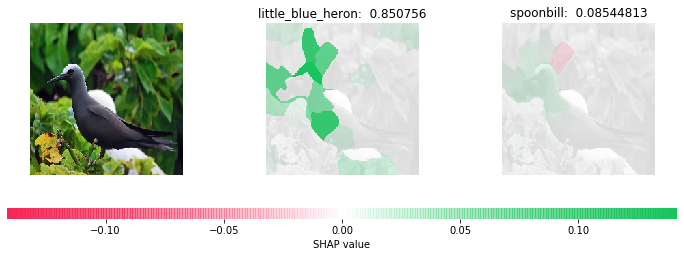

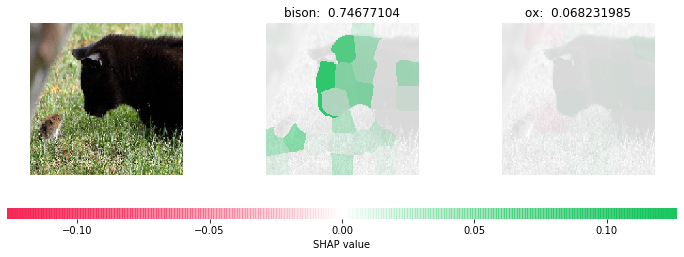

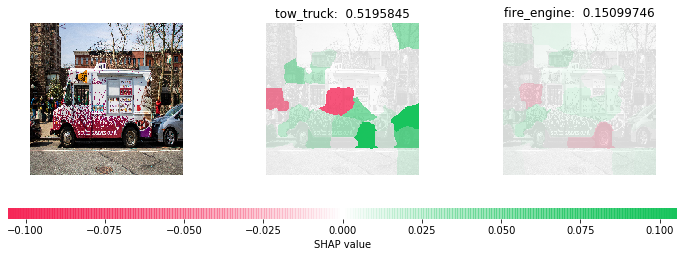

In [8]:
fig_list = []
for i in range(len(files)):
    # get the top predictions from the model
    preds = model.predict(preprocess_input(np.expand_dims(img_arr_list[i].copy(), axis=0)))
    labels = decode_predictions(preds, top=top_n)[0]
    fig = utils.show_explanation(img_list[i], n_segments, shap_values_list[i], labels, preds)
    fig_list.append(fig)

In [9]:
for count, item in enumerate(fig_list):
    fig = item
    name = files[count].split('/')[-1].split('.')[0]+'_explain'
    run.log_image(name, plot=fig)
run.tag('ImageSuperPixel')
run.complete()
run

Experiment,Id,Type,Status,Details Page,Docs Page
demo,31a69cc7-aad2-46eb-b8eb-b43da8af2098,,Running,Link to Azure Machine Learning studio,Link to Documentation
